In [1]:
import math
import random

import numpy as np
from numba import njit, prange
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def gen_ring_sample(c: tuple, r1: float, r2: float, n: int):
        data = []
    
        for i in range(n):
            angle = random.uniform(0, 2*math.pi)
            dist = random.uniform(r1, r2)

            data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
        
        return np.array(data)

def gen_circle_smaple(c: tuple, r: float, n: int):
    data = []
    
    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        dist = random.uniform(0, r)

        data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
    
    return np.array(data)

In [3]:
@njit(fastmath=True)
def reduce_density(points: np.ndarray, sep_factor: float, niter: int):
    for k in prange(niter):
        forces = np.zeros(points.shape)
        for i in prange(points.shape[0]):
            force_i = np.zeros(points.shape[1], dtype=float)
            for j in range(points.shape[0]):
                d = np.linalg.norm(points[i]-points[j])
                force_i += np.exp(-sep_factor*d)*(points[i]-points[j])
            forces[i] = force_i
        points += forces

In [31]:
@njit(fastmath=True)
def find_winner(p: np.ndarray, x: np.ndarray):
    return np.argmin(np.array([np.sum(np.square(x-w)) for w in p]))


@njit(fastmath=True)
def update_weight(x: np.ndarray, p: np.ndarray, c: int, alpha: float, beta: float, gamma: float, t: float) -> np.ndarray:
    d = np.sum(np.square(p[c]-p), axis=1)
    s = np.atleast_2d(np.exp(-gamma*d/t**2)).T
    
    return alpha*s*(x-p)


class SOM:
    def __init__(self, n, alpha, beta, gamma) -> None:
        self.n: int = n
        self.p: np.ndarray = None
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma


    def _init_weights(self, data: np.ndarray):
        self.p = np.random.uniform(-1, 1, (self.n, data.shape[1]))
        
        reduce_density(self.p, 10, 100)
        
        for i in range(self.p.shape[1]):
            self.p[:,i] = -1+(self.p[:,i]-self.p[:,i].min())/(self.p[:,i].max()-self.p[:,i].min())*2


    def fit(self, data: np.ndarray, n_iter: int) -> None:
        
        self._init_weights(data)
        
        for t in range(n_iter):
            x = random.choice(data)
            
            c = find_winner(self.p, x)
            
            forces = update_weight(
                x,
                self.p,
                c,
                self.alpha,
                self.beta,
                self.gamma,
                1/(1+t)
            )

            self.p += forces

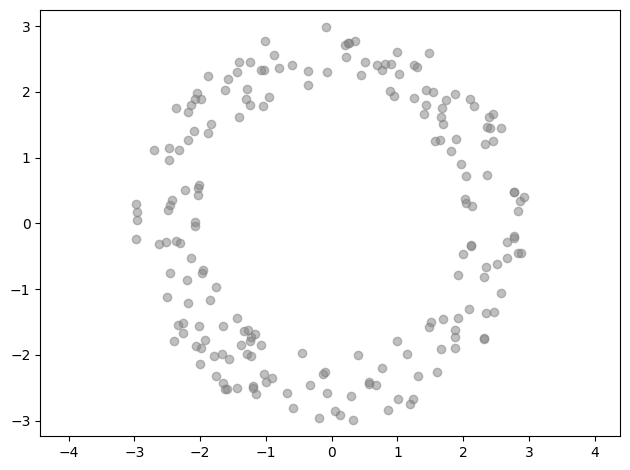

In [5]:
sample1 = gen_circle_smaple((0,0), 1, 100)
sample2 = gen_ring_sample((0,0), 2,3, 200)

data = np.vstack((sample2))
# data = np.array(sample2)

plt.scatter(data[:,0], data[:,1], c='gray', alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [36]:
m = 15
n = m**2

alpha = 1e-2
beta = 1e-1
gamma = 1e-3

n_iter = 30000

model = SOM(n, alpha, beta, gamma)
model.fit(data, n_iter)

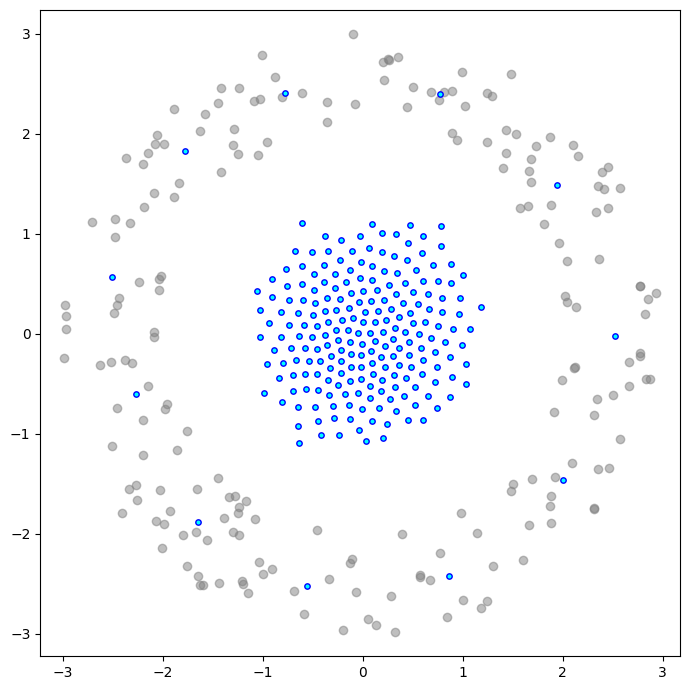

In [37]:
fig = plt.figure(figsize=(7,7), dpi=100)
ax = fig.add_subplot()


ax.scatter(data[:,0], data[:,1], c='gray', alpha=0.5)
ax.scatter(model.p[:, 0], model.p[:, 1], s=15,
                 c='cyan', edgecolors='blue')

plt.axis('equal')
plt.tight_layout()
plt.show()

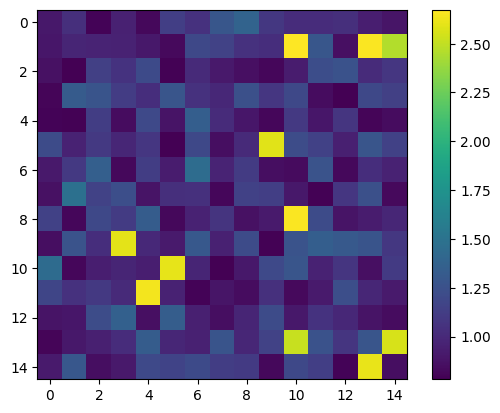

In [38]:
avg_dists = np.zeros(n)

for i,p in enumerate(model.p):
    avg_dists[i] = np.mean(np.array([np.linalg.norm(p-pi) for pi in model.p]))

img = plt.imshow(avg_dists.reshape((m,m)))

plt.colorbar(img)

plt.show()

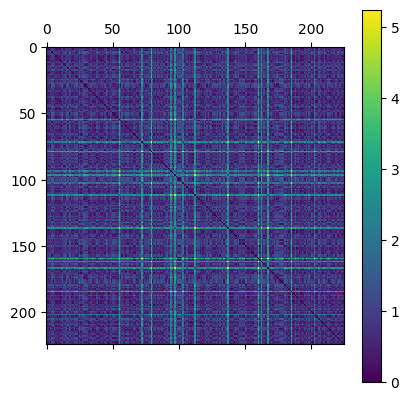

In [9]:
distances = np.array(
    [[np.linalg.norm(a-b) for b in model.p] for a in model.p]
)

img = plt.matshow(distances)
plt.colorbar(img)
plt.show()

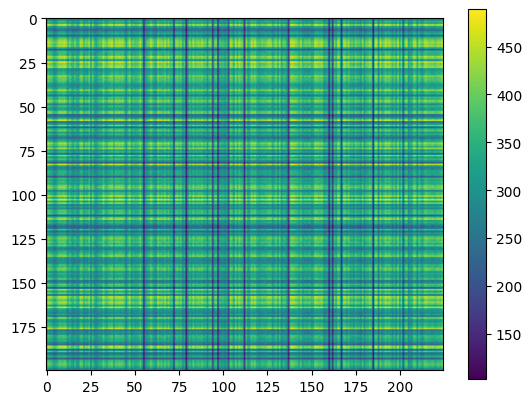

In [10]:
y = []
for x in data:
    # a = np.exp(-np.sum(np.square(x-model.p), axis=1))
    a = np.sqrt(np.sum(np.square(x-model.p), axis=1))
    y.append(np.dot(1/(distances+1), a))
    

img = plt.imshow(y)
plt.colorbar(img)
plt.show()